# Homework 02 (classic ML edition)

Your task is to train a model that will improve upon at least one of the baselines provided
- Any classic ML model can be used
- You can engineer more features if you want, e.g. holidays
- You can use feature selection methods not from `tsfresh`

In [17]:
!pip install numpy pandas matplotlib seaborn

In [18]:
import numpy as np
import pandas as pd

import pickle

import IPython.display as dp
import matplotlib.pyplot as plt
import seaborn as sns

dp.set_matplotlib_formats("retina")
sns.set(style="whitegrid", font_scale=1.5)
sns.despine()

%matplotlib inline

/tmp/ipython-input-2758882091.py:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  dp.set_matplotlib_formats("retina")


<Figure size 640x480 with 0 Axes>

## Load data

Please choose one stock ticker of your liking.

In [19]:
!git clone https://github.com/zhouhaoyi/ETDataset.git

fatal: destination path 'ETDataset' already exists and is not an empty directory.


In [20]:
data = pd.read_csv('ETDataset/ETT-small/ETTh1.csv')

In [21]:
data.head()

,date,HUFL,HULL,MUFL,MULL,LUFL,LULL,OT
0,2016-07-01 00:00:00,5.827,2.009,1.599,0.462,4.203,1.340,30.531000
1,2016-07-01 01:00:00,5.693,2.076,1.492,0.426,4.142,1.371,27.787001
2,2016-07-01 02:00:00,5.157,1.741,1.279,0.355,3.777,1.218,27.787001
3,2016-07-01 03:00:00,5.090,1.942,1.279,0.391,3.807,1.279,25.044001
4,2016-07-01 04:00:00,5.358,1.942,1.492,0.462,3.868,1.279,21.948000


In [22]:
data_ticker = data.set_index("date")["OT"]

In [23]:
data_ticker = data_ticker.sort_index().reset_index()

In [24]:
data_ticker["id"] = 0

In [25]:
data_ticker.head()

,date,OT,id
0,2016-07-01 00:00:00,30.531000,0
1,2016-07-01 01:00:00,27.787001,0
2,2016-07-01 02:00:00,27.787001,0
3,2016-07-01 03:00:00,25.044001,0
4,2016-07-01 04:00:00,21.948000,0


<Axes: xlabel='date'>

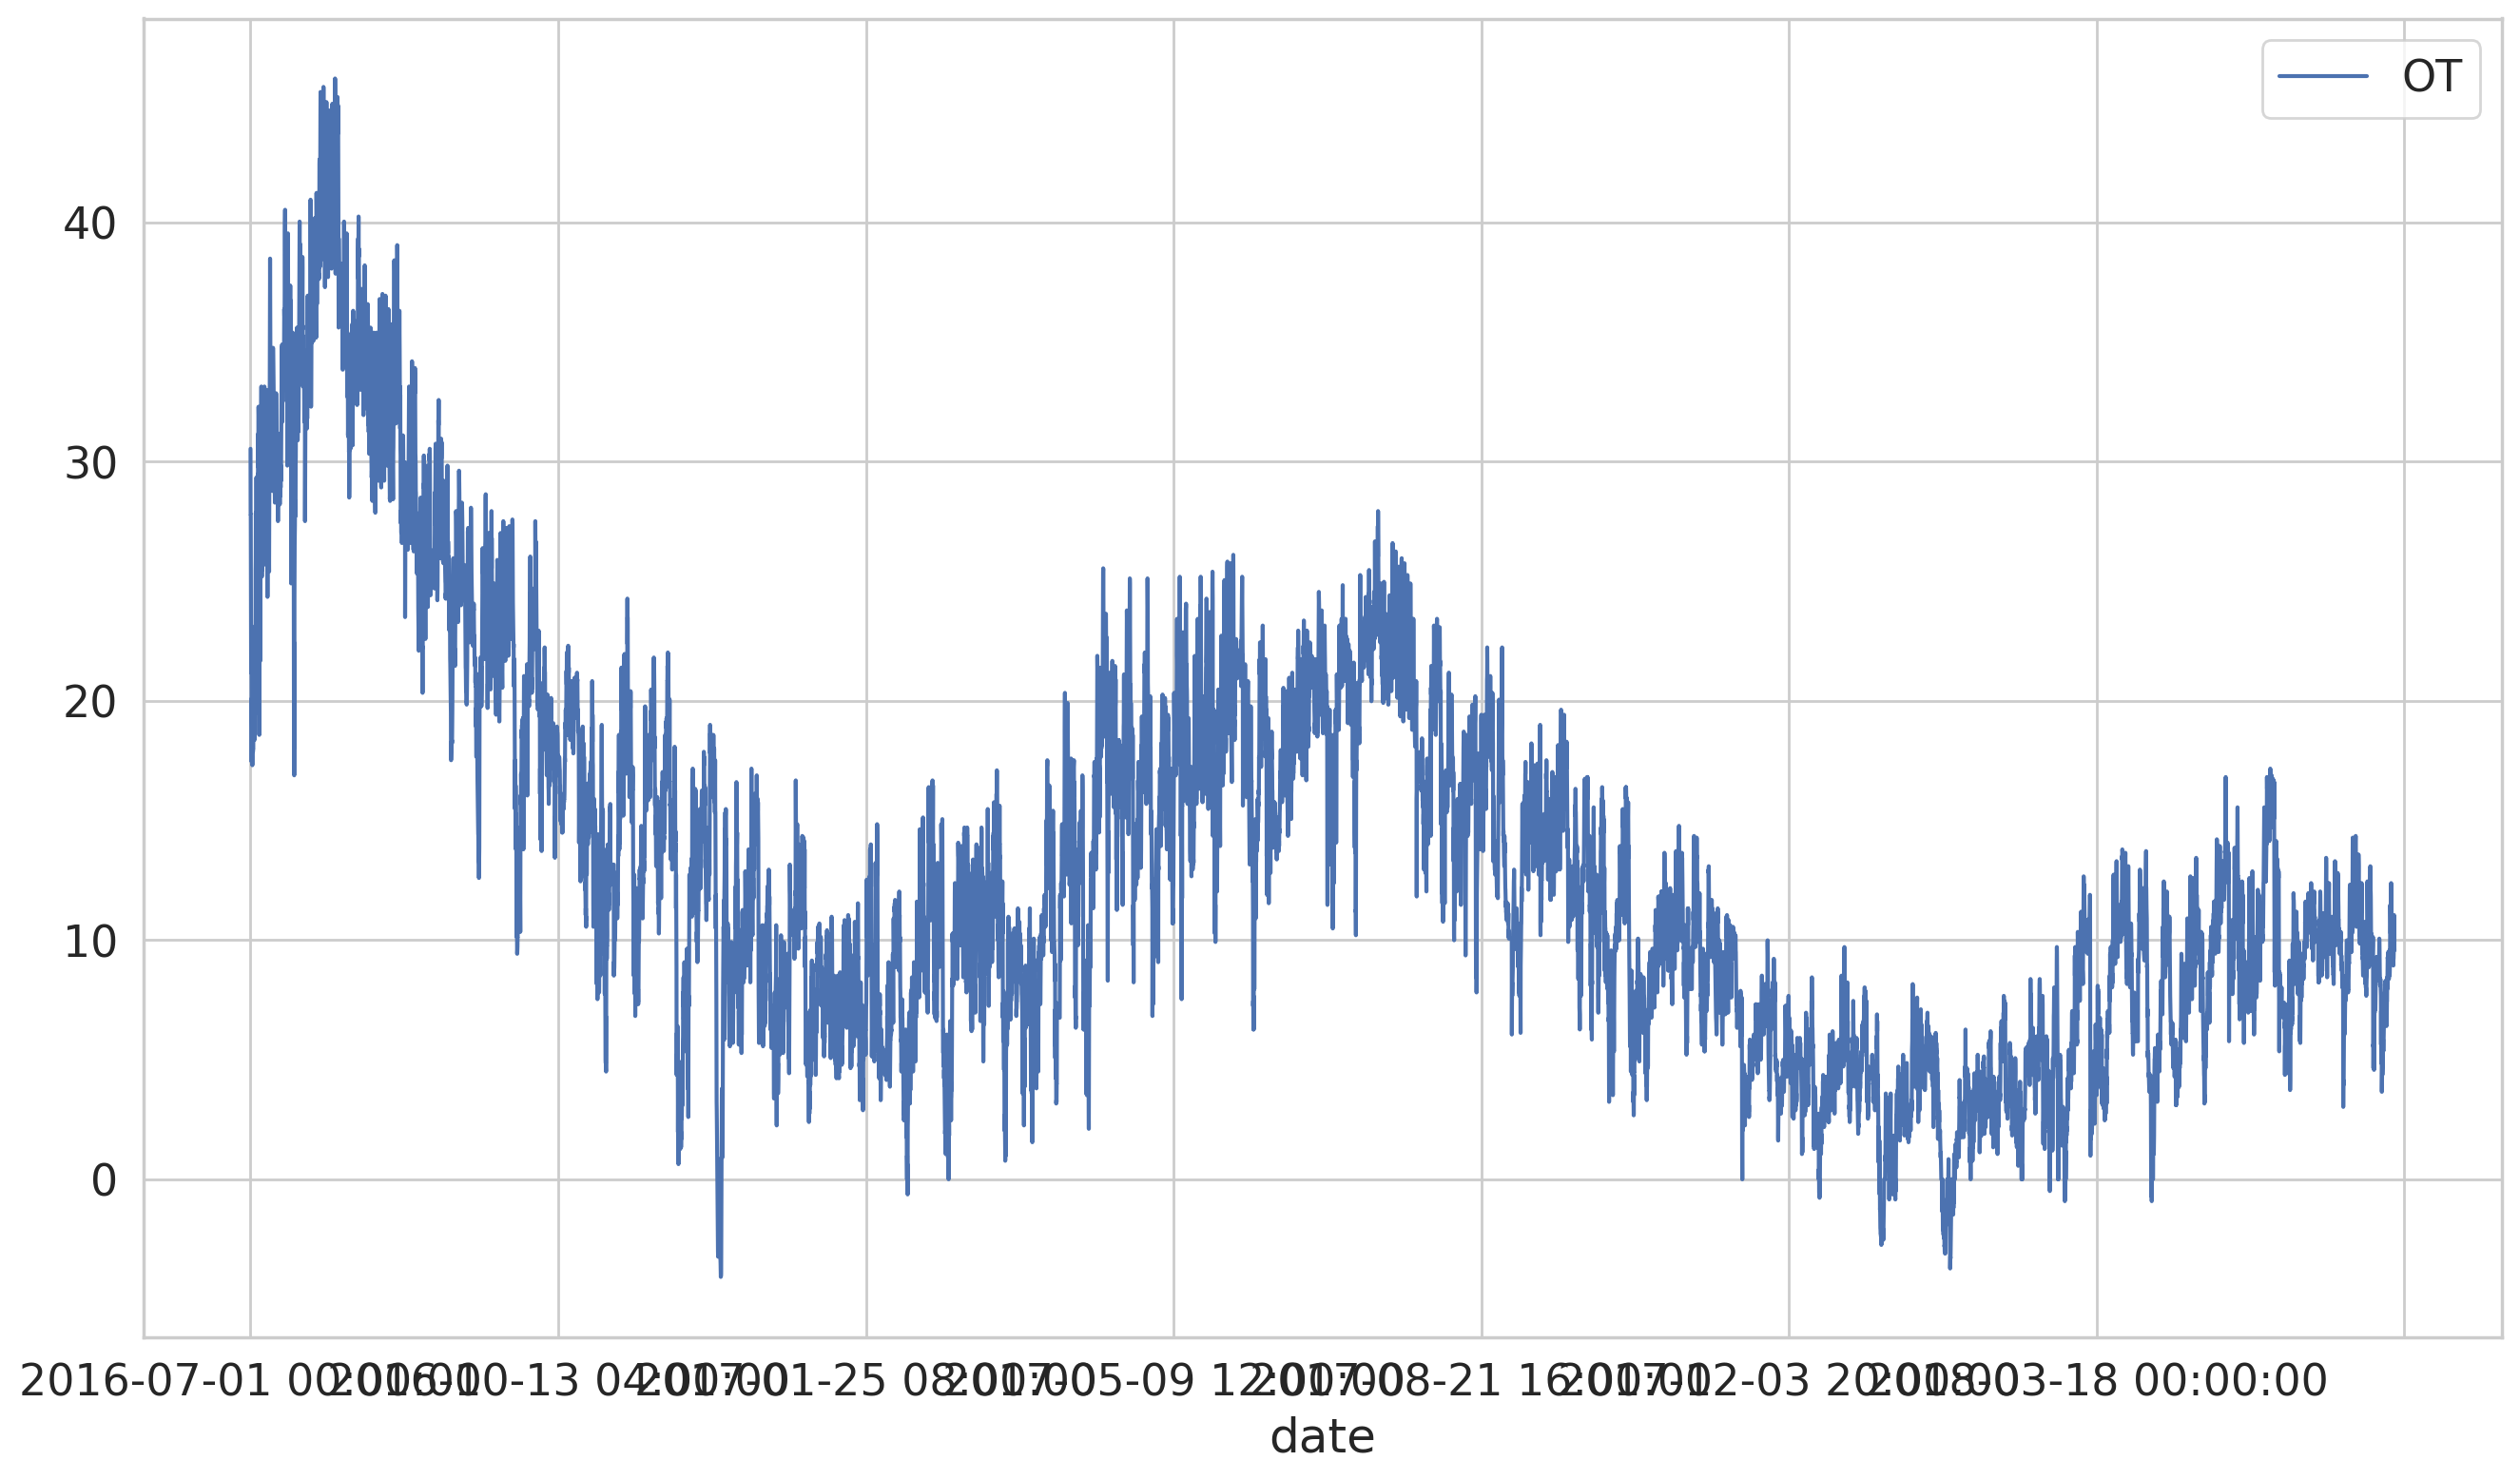

In [26]:
fig, ax = plt.subplots(figsize=(16,9))
data_ticker.plot(x="date", y="OT", ax=ax)

# Preprocessing check

In [27]:
data["date"] = pd.to_datetime(data["date"])
data = data.sort_values("date")

print("rows:", len(data))
print("date dtype:", data["date"].dtype)
print("duplicate dates:", data["date"].duplicated().sum())
print("OT NaNs:", data["OT"].isna().sum())


rows: 17420
date dtype: datetime64[ns]
duplicate dates: 0
OT NaNs: 0


In [28]:
data_ticker = data[["date", "OT"]].copy()
data_ticker["OT"] = pd.to_numeric(data_ticker["OT"], errors="coerce")

if data_ticker["OT"].isna().any():
    data_ticker["OT"] = data_ticker["OT"].ffill().bfill()
deltas = data_ticker["date"].diff().dropna()
data_ticker["id"] = 0

data_ticker.head()

,date,OT,id
0,2016-07-01 00:00:00,30.531000,0
1,2016-07-01 01:00:00,27.787001,0
2,2016-07-01 02:00:00,27.787001,0
3,2016-07-01 03:00:00,25.044001,0
4,2016-07-01 04:00:00,21.948000,0


## Create features

We will be working with classic machine learning methods in this assignment, so we must supply fixed sized input. In order to work with sequences of variable size within this setting, windowing is used. `tsfresh` provides windowing through `roll_time_series` function. Please familiarize yourself with its arguments and make sure to understand the operation it performs on the data.

You can also add other features from the original dataframe, but be careful to use them correctly with the windowing approach.

In [29]:
from tsfresh import extract_features
from tsfresh.utilities.dataframe_functions import roll_time_series, make_forecasting_frame
from tsfresh.utilities.dataframe_functions import impute

In [30]:
data_rolled = roll_time_series(
    data_ticker,
    column_id="id",
    column_sort="date",
    max_timeshift=24 * 7,
    min_timeshift=24 * 1,
)

Rolling: 100%|██████████| 17420/17420 [01:42<00:00, 170.05it/s]


In [31]:
data_rolled.head()

,date,OT,id
0,2016-07-01 00:00:00,30.531000,"(0, 2016-07-02 00:00:00)"
1,2016-07-01 01:00:00,27.787001,"(0, 2016-07-02 00:00:00)"
2,2016-07-01 02:00:00,27.787001,"(0, 2016-07-02 00:00:00)"
3,2016-07-01 03:00:00,25.044001,"(0, 2016-07-02 00:00:00)"
4,2016-07-01 04:00:00,21.948000,"(0, 2016-07-02 00:00:00)"


Now that we have inputs of equal size (one `id` is one sample), we can create features for them using `tsfresh.extract_features`. Please familiarize yourself with its arguments.

In [32]:
from google.colab import drive
import os

Serialized due to the extreme amount of time to calculate

In [35]:
drive.mount("/content/drive")
CACHE_DIR = "/content/drive/MyDrive/tsfresh_cache"
os.makedirs(CACHE_DIR, exist_ok=True)
CACHE_PATH = os.path.join(CACHE_DIR, "ETTh1_OT_tsfresh_X.parquet")

if os.path.exists(CACHE_PATH):
    X = pd.read_parquet(CACHE_PATH)
    X.index = pd.to_datetime(X.index)
    X.index.name = "last_date"
    print("Loaded cached:", X.shape)
else:
    print("Cache is not found. Computing..")
    X = extract_features(
        data_rolled.fillna(0),
        column_id="id",
        column_sort="date",
        column_value="OT",
        impute_function=impute,
        show_warnings=False
    )
    X = X.set_index(X.index.map(lambda x: x[1]), drop=True)
    X.index = pd.to_datetime(X.index)
    X.index.name = "last_date"

    X.to_parquet(CACHE_PATH)
    print("Computed and saved", X.shape)


Mounted at /content/drive
Cache is not found. Computing..


Feature Extraction: 100%|██████████| 17396/17396 [59:29<00:00,  4.87it/s]


Computed and saved (17396, 783)


In [94]:
X.columns

Index(['OT__variance_larger_than_standard_deviation', 'OT__has_duplicate_max',
       'OT__has_duplicate_min', 'OT__has_duplicate', 'OT__sum_values',
       'OT__abs_energy', 'OT__mean_abs_change', 'OT__mean_change',
       'OT__mean_second_derivative_central', 'OT__median',
       ...
       'OT__fourier_entropy__bins_100',
       'OT__permutation_entropy__dimension_3__tau_1',
       'OT__permutation_entropy__dimension_4__tau_1',
       'OT__permutation_entropy__dimension_5__tau_1',
       'OT__permutation_entropy__dimension_6__tau_1',
       'OT__permutation_entropy__dimension_7__tau_1',
       'OT__query_similarity_count__query_None__threshold_0.0',
       'OT__mean_n_absolute_max__number_of_maxima_7', 'is_holiday',
       'is_holiday_next'],
      dtype='object', length=785)

In [95]:
y = data_ticker.set_index("date").sort_index()['OT'].shift(-1).dropna()

In [96]:
common_index = X.index.intersection(y.index)
X = X.loc[common_index]
y = y.loc[common_index]

In [97]:
print("aligned:", X.shape, y.shape)
print("X range:", X.index.min(), "->", X.index.max())
print("y range:", y.index.min(), "->", y.index.max())

aligned: (17395, 785) (17395,)
X range: 2016-07-02 00:00:00 -> 2018-06-26 18:00:00
y range: 2016-07-02 00:00:00 -> 2018-06-26 18:00:00


In [98]:
!pip -q install holidays

import holidays

hcal = holidays.country_holidays("CN") #датасет китайский, судя по именам и прочему..

last_dates = pd.to_datetime(X.index)

X["is_holiday"] = pd.Series(last_dates.normalize().date, index=X.index).isin(hcal).astype(int)
X["is_holiday_next"] = pd.Series((last_dates + pd.Timedelta(hours=1)).normalize().date, index=X.index).isin(hcal).astype(int)
X[["is_holiday", "is_holiday_next"]].head()

,is_holiday,is_holiday_next
2016-07-02 00:00:00,0,0
2016-07-02 01:00:00,0,0
2016-07-02 02:00:00,0,0
2016-07-02 03:00:00,0,0
2016-07-02 04:00:00,0,0


In [99]:
X_train = X[:"2018"]
X_test = X["2018":]

y_train = y[:"2018"]
y_test = y["2018":]

In [100]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(17395, 785) (4243, 785) (17395,) (4243,)


# Moddel checks

In [101]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

In [102]:
pipe = Pipeline([("imp", SimpleImputer(strategy="median")),("sc", StandardScaler()),
    ("pca", PCA(n_components=50, random_state=67)),("rg", Ridge(alpha=3.0))])

pipe.fit(X_train, y_train)
y_pred= pipe.predict(X_test)

mse_model= mean_squared_error(y_test, y_pred)
print("PCA+Ridge MSE:", mse_model)

PCA+Ridge MSE: 0.7353993629287948


In [103]:
from sklearn.ensemble import HistGradientBoostingRegressor

gb = Pipeline([("imp", SimpleImputer(strategy="median")), ("gb", HistGradientBoostingRegressor(learning_rate= 0.05,
        max_depth= 6, max_iter= 600, random_state=67))])

gb.fit(X_train, y_train)
y_pred_gb= gb.predict(X_test)

mse_gb= mean_squared_error(y_test, y_pred_gb)
print("HGBR MSE:", mse_gb)


HGBR MSE: 0.25540425815557977


## Select features

`tsfresh` generates too many features for classic ML models that suffer from curse of dimensionality, so we need to choose the most representative features. `tsfresh` provides a function `select_features` for this purpose. You can use this function, or you can use PCA or any other feature selection / dimensionality reduction method that you know. If you choose to not use `tsfresh.select_features`, please still familiarize yourself with its arguments.

In [104]:
from tsfresh import select_features

In [105]:
X_train_selected = select_features(X_train, y_train)

In [106]:
X_test_selected = X_test[X_train_selected.columns]

In [107]:
X_train_selected.shape

(17395, 630)

In [108]:
prep = Pipeline([("imp", SimpleImputer(strategy="median")), ("sc", StandardScaler()),
    ("pca", PCA(n_components= 50, random_state= 67))])

X_train_pca= prep.fit_transform(X_train_selected)
X_test_pca= prep.transform(X_test_selected)

print(X_train_pca.shape, X_test_pca.shape)


(17395, 50) (4243, 50)


## Preprocess features

You are welcome to perform some preprocessing steps that may improve the quality of your model. Please note that evaluation must be done on the original features.

In [109]:
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

In [110]:
imp = SimpleImputer(strategy="median")
scaler = StandardScaler()

X_train_proc = pd.DataFrame(scaler.fit_transform(imp.fit_transform(X_train_selected)),
    index=X_train_selected.index, columns=X_train_selected.columns)

X_test_proc = pd.DataFrame(scaler.transform(imp.transform(X_test_selected)),
    index=X_test_selected.index, columns=X_test_selected.columns)

print("Processed shapes:", X_train_proc.shape, X_test_proc.shape)


Processed shapes: (17395, 630) (4243, 630)


## Baselines

I have created three baselines for you. Your task will be to beat at least the first one. If you beat the rolling mean baseline, you will get bonus points. You are also free to introduce our own baselines, e.g. linear regression.

In [131]:
from sklearn.metrics import mean_squared_error

In [132]:
mean_squared_error(y_test, y_test.shift(1).fillna(0))

0.418369516695407

In [133]:
mean_squared_error(y_test, np.ones_like(y_test) * y_test.mean())

15.072377596039832

In [134]:
mean_squared_error(y_test, y_test.shift(1).rolling(window=3).mean().bfill().ffill())

0.6401646738755165

## Train a model

- Pick any ML model of your liking
- Fit it to the selected (and possibly preprocessed) features on the train set
- You can do cross-validation to pick hyperparameters, but be careful not to train on future!
- Make a prediction on the test set
- If necessay, make an inverse transform

In [136]:
from sklearn.ensemble import HistGradientBoostingRegressor

In [137]:
gb= Pipeline([("imp", SimpleImputer(strategy="median")),
 ("gb", HistGradientBoostingRegressor(learning_rate= 0.05, max_depth= 6, max_iter= 1000, random_state= 67))])

gb.fit(X_train_selected, y_train)
y_pred_gb_sel= gb.predict(X_test_selected)

mse_gb_sel= mean_squared_error(y_test, y_pred_gb_sel)
print("HGBR, select_features MSE:", mse_gb_sel)

HGBR, select_features MSE: 0.2759625630352241


In [138]:
Xtr, Xte = X_train_selected, X_test_selected

def pca_ridge_mse(n_comp, alpha=3.0):
    pipe = Pipeline([("imp", SimpleImputer(strategy= "median")), ("sc", StandardScaler()), ("pca", PCA(n_components=n_comp, random_state=67)),
        ("rg", Ridge(alpha=alpha))])

    pipe.fit(Xtr, y_train)
    pred= pipe.predict(Xte)
    return mean_squared_error(y_test, pred)

for n in [10, 20, 50, 100, 200, 300, 350, 400, 450, 500, 600]:
    print(n, pca_ridge_mse(n, alpha=3.0))


10 1.594606317531856
20 1.0603874266427873
50 0.7137918995812191
100 0.6368086138976916
200 0.5310767200456321
300 0.4587666188023612
350 0.4467295496893888
400 0.395100170342457
450 0.3894948670653761
500 0.388367136014616
600 0.38660166946220254


Thus, HGBR on full features is the best and beats both baselines.

## Compare quality

Please make a qualitative (plots) and quantitative (quality measures) comparison between your model and the baselines.

In [146]:
import matplotlib.pyplot as plt

pred_prev = y_test.shift(1).fillna(0)
pred_mean = pd.Series(y_train.mean(), index=y_test.index)
pred_roll3 = y_test.shift(1).rolling(window=3, min_periods=1).mean().fillna(0)
pred_roll3.iloc[0] = pred_roll3.iloc[1]
pred_prev.iloc[0] = pred_prev.iloc[1]

pred_model = pd.Series(y_pred, index=y_test.index)

results = pd.DataFrame({
    "baseline_prev": [mean_squared_error(y_test, pred_prev)],
    "baseline_mean": [mean_squared_error(y_test, pred_mean)],
    "baseline_roll3_shift": [mean_squared_error(y_test, pred_roll3)],
    "model": [mean_squared_error(y_test, y_pred_gb_sel)],
}, index=["MSE"]).T.sort_values("MSE")

display(results)

,MSE
model,0.275963
baseline_prev,0.413593
baseline_roll3_shift,0.640210
baseline_mean,57.910012


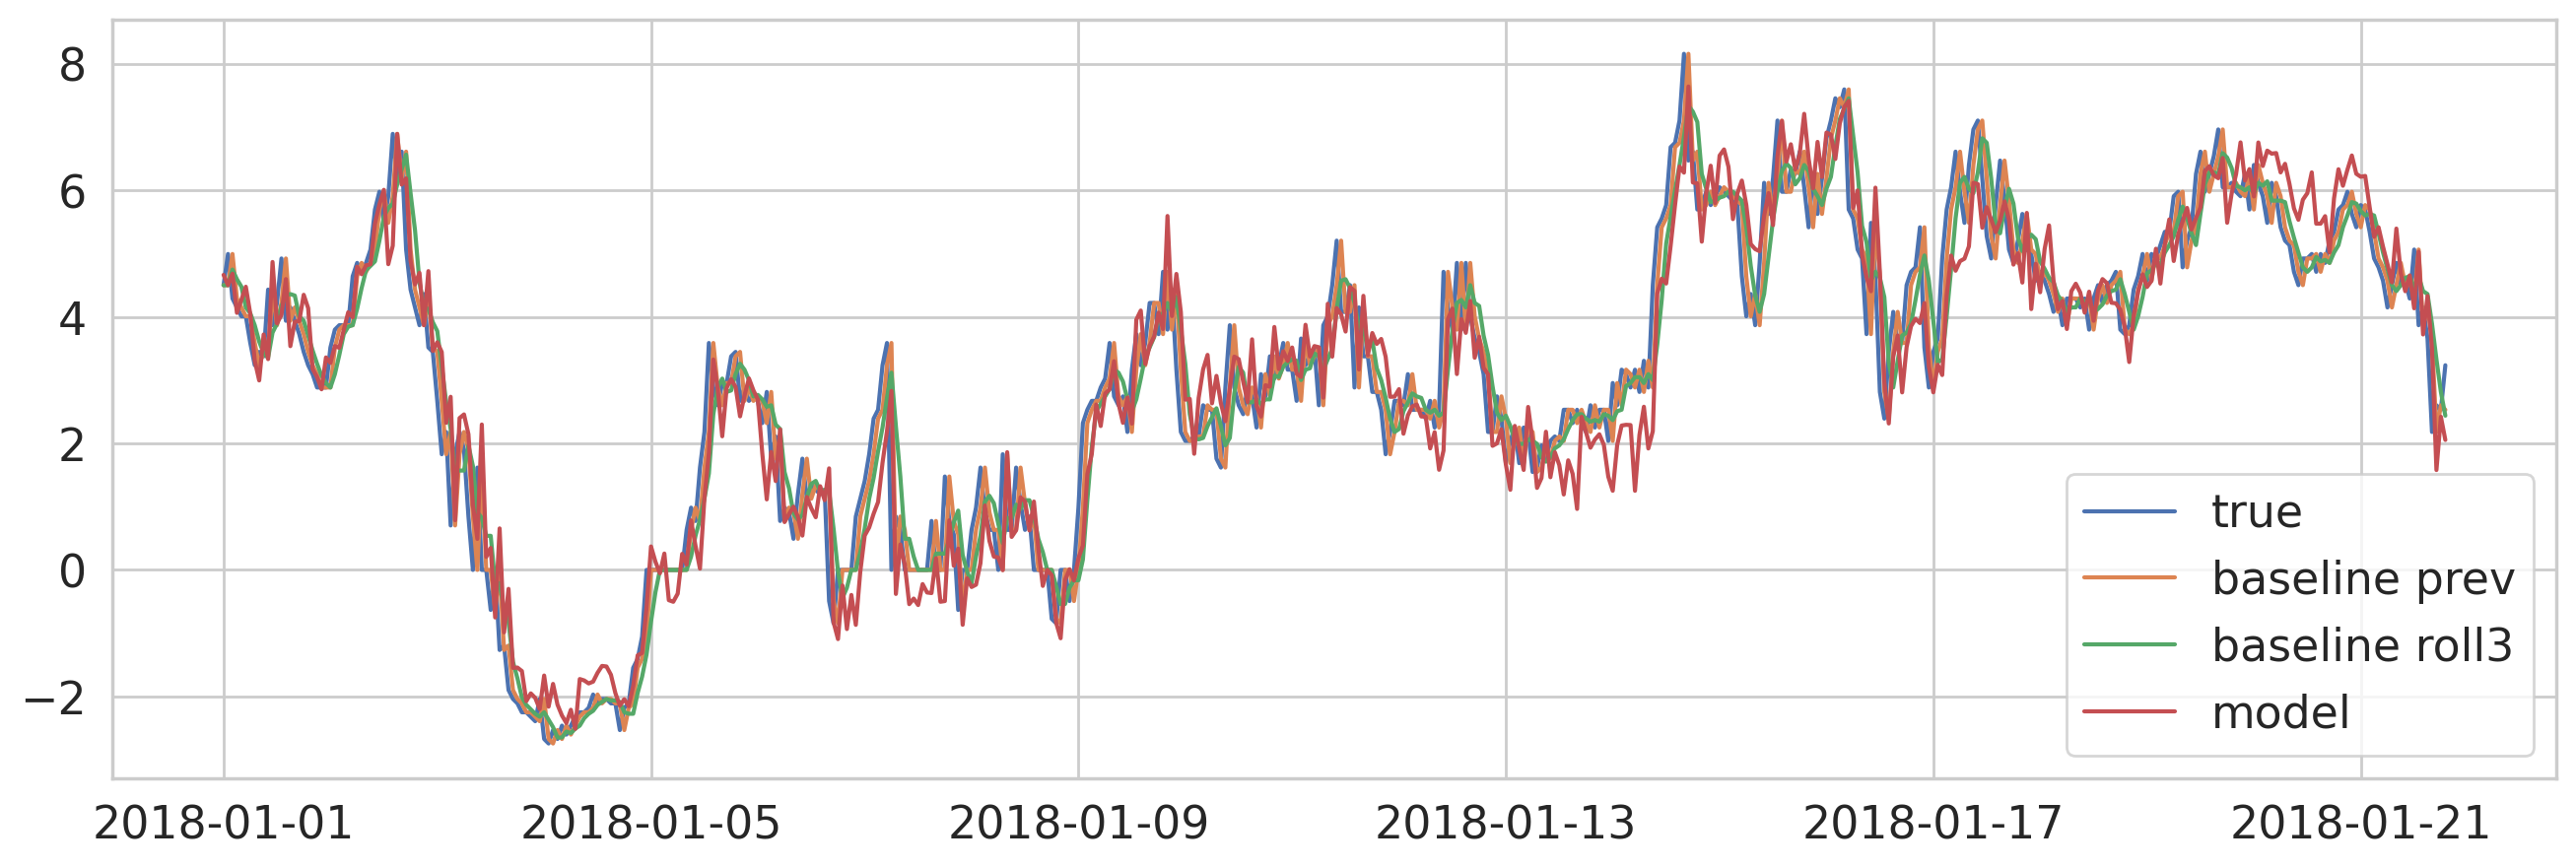

In [147]:
N = 500
plt.figure(figsize=(16,5))
plt.plot(y_test.iloc[:N].index, y_test.iloc[:N].values, label="true")
plt.plot(pred_prev.iloc[:N].index, pred_prev.iloc[:N].values, label="baseline prev")
plt.plot(pred_roll3.iloc[:N].index, pred_roll3.iloc[:N].values, label="baseline roll3")
plt.plot(pred_model.iloc[:N].index, pred_model.iloc[:N].values, label="model")
plt.legend()


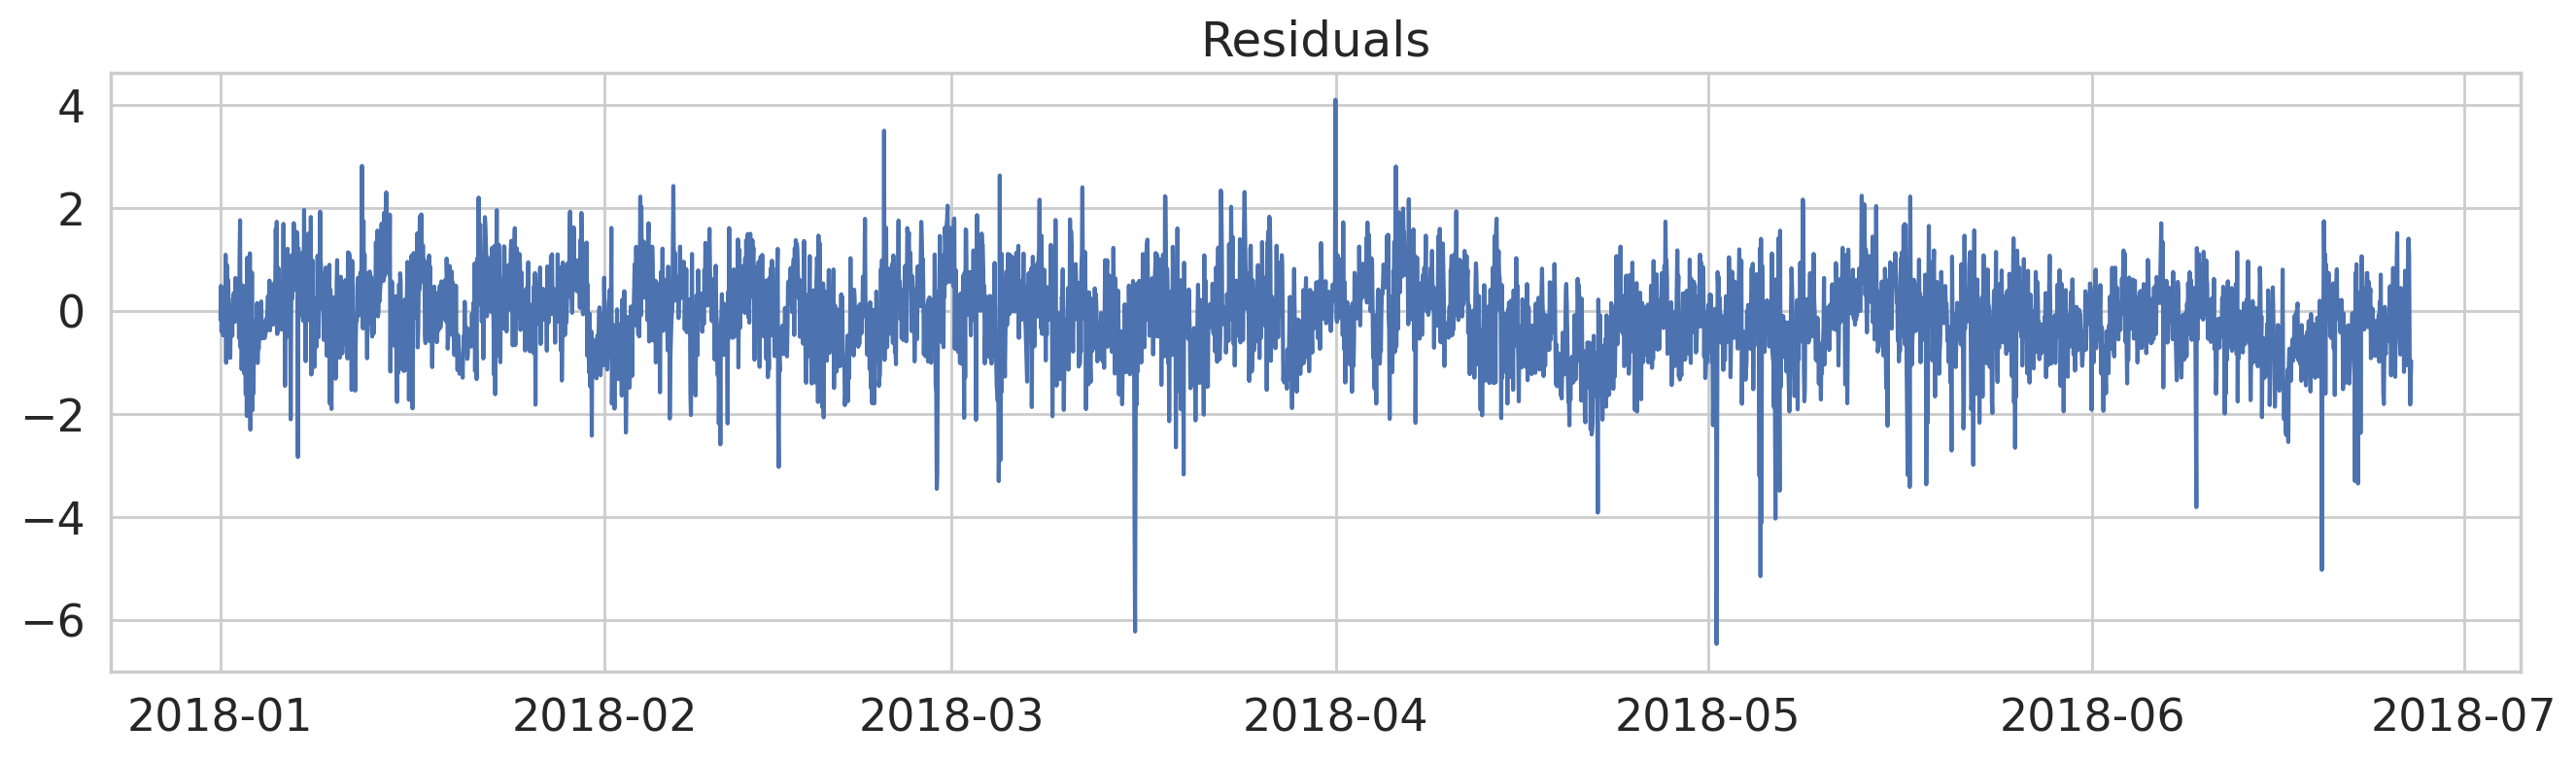

In [145]:
resid = y_test - pred_model
plt.figure(figsize=(16,4))
plt.plot(resid.index, resid.values)
plt.title("Residuals")
plt.show()
